In [1]:
from skimage.io import imread, imsave
from skimage.transform import rotate, rescale
from random import randint
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from imgaug import augmenters as iaa
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
print(tf.__version__)

ModuleNotFoundError: No module named 'imgaug'

# Define params and helpers

In [2]:
path_data_train = './data/train/'
path_data_augmented_rotation = './data/aug/rotation'
path_data_augmented_blur = './data/aug/blur/'
path_data_augmented_mixup = './data/aug/mixup/'
path_data_test = './data/test/'
num_classes = 12

# Read images

In [3]:
img_dict = {}
for i in range(num_classes):
    img_list = []
    files = os.listdir(path_data_train + '/' + str(i) + '/')
    for file in files:
        img = imread(path_data_train + '/' + str(i) + '/' + file)
        img_list.append(img)
    img_dict[i] = img_list

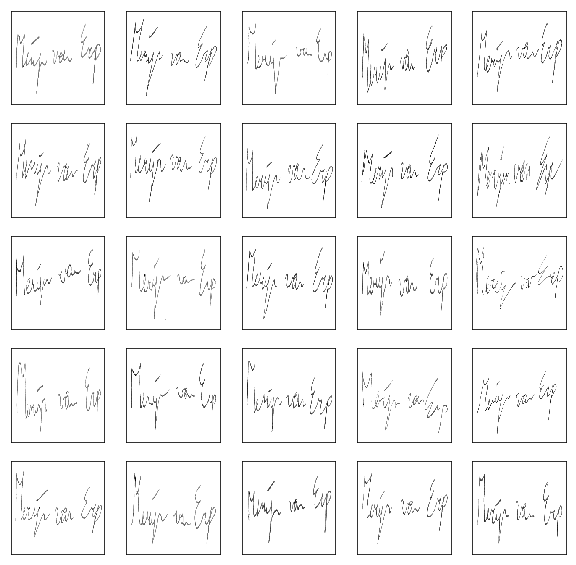

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_dict[0][i], cmap='gray')

# Rotation

In [5]:
img_dict_rot = {}
for i in range(num_classes):
    images = img_dict[i][0:50]
    seq = iaa.Sequential([iaa.Affine(
    rotate=(-10, 10), 
    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
    cval = (255) )])
    images_aug = seq.augment_images(images)
    #img_dict[i] = img_dict[i]+images_aug
    img_dict_rot[i] = images_aug
    for k in range(len(images_aug)):
        cv2.imwrite(path_data_augmented_rotation + '/' + str(i) + '/'+ str(k)+'.PNG', images_aug[k])

# Gussian blur

In [6]:
img_dict_blur = {}
for i in range(num_classes):
    images = img_dict[i][0:25]
    images = images+img_dict_rot[i][0:25]
    seq = iaa.Sequential([
    
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
    ])
    
    
    images_aug = seq.augment_images(images)
    #img_dict[i] = img_dict[i]+images_aug
    img_dict_blur[i] = images_aug
    for k in range(len(images_aug)):
        cv2.imwrite(path_data_augmented_blur + '/' + str(i) + '/'+ str(k)+'.PNG', images_aug[k])

# Mixup

In [7]:
import random
for i in range(num_classes):
    for j in range(len(img_dict[i])):
        a = random.randint(0,(num_classes-1))
        b = random.randint(0,(len(img_dict[a])-1))
        mixup = img_dict[i][j]*0.95 + img_dict[a][b]*0.05
        cv2.imwrite(path_data_augmented_mixup + '/' + str(i) + '/'+ str(j)+'.PNG', mixup)

# Load Images and Labels


In [8]:
from keras.preprocessing.image import ImageDataGenerator
train = ImageDataGenerator().flow_from_directory(path_data_train, target_size=(224,224))
test = ImageDataGenerator().flow_from_directory(path_data_test, target_size=(224,224))

Using TensorFlow backend.


Found 1518 images belonging to 12 classes.
Found 380 images belonging to 12 classes.


In [9]:
imgs, labels = next(train)

In [10]:
# plot images with Labels within jupyter notebook
def plots(ims,figsize=(12,6), rows=1, interp = False, titles = None):
  if type(ims[0]) is np.ndarray:
    ims = np.array(ims).astype(np.uint8)
    if (ims.shape[-1] != 3):
      ims = ims.transpose((0,2,3,1))
  f = plt.figure(figsize=figsize)
  cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
  for i in range(len(ims)):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize=16)
    plt.imshow(ims[i], interpolation = None if interp else 'none')

c:\program files\python36\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


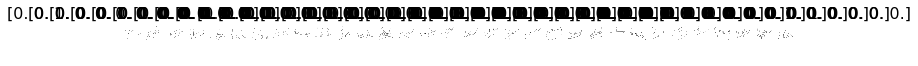

In [11]:
plots(imgs, titles=labels)

# Model